In [9]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [10]:
bbb_df = pd.read_csv('adenot.csv')
bbb_df

,Drug,SMILES,permeable
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0
...,...,...,...
1666,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1
1667,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1
1668,DISULFIRAM,CCN(CC)C(=S)SSC(=S)N(CC)CC,1
1669,MORPHINE,CN1CC[C@@]23[C@H]4Oc5c(ccc(c52)C[C@@H]1[C@@H]3...,1


In [11]:
bbb_df[bbb_df['Drug'] == 'COBALAMINE']

,Drug,SMILES,permeable


## Getting Fingerprints

In [12]:
r = 2
d = 1024

fp_list = []
for smile in bbb_df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        print('invalid SMILES')
        bbb_df = bbb_df[bbb_df['SMILES'] != smile]
    else: 
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,r,nBits=d,useChirality=False)
        fp_list.append(fp)

morgan_list = np.array(fp_list)
print(morgan_list.shape)
print(bbb_df.shape)

[15:52:55] SMILES Parse Error: syntax error while parsing: CO[C@]1(NC(=O)CSC[C@@H]([N+H3])C([O-])=O)[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc1nnnn1C
[15:52:55] SMILES Parse Error: Failed parsing SMILES 'CO[C@]1(NC(=O)CSC[C@@H]([N+H3])C([O-])=O)[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc1nnnn1C' for input: 'CO[C@]1(NC(=O)CSC[C@@H]([N+H3])C([O-])=O)[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc1nnnn1C'


invalid SMILES
(1670, 1024)
(1670, 3)


## K-Means Clustering

In [18]:
k = 3
kmeans = KMeans(n_clusters=k).fit(morgan_list)
cluster_index = kmeans.predict(morgan_list)

In [19]:
count = np.bincount(cluster_index)
index = np.arange(len(count))
number = [i for i in count]
percent = [round(100*i/len(cluster_index), 2) for i in number]

cluster_df = pd.DataFrame(
    {'cluster_index': index,
    'number': number,
    'percentage': percent
    }, index = None)

cluster_df

,cluster_index,number,percentage
0,0,1175,70.36
1,1,338,20.24
2,2,157,9.40


## Principal Component Analysis

In [20]:
dim = 100
pca = PCA(n_components=dim)
components = pca.fit_transform(morgan_list)

In [21]:
print("Overall Variance Captured by PCA-1 and PCA-2: ", sum(pca.explained_variance_ratio_[0:2]))
print("50 Principal Components Total Explained Variance: ", sum(pca.explained_variance_ratio_))
print("Fraction of Overall Variance Captured: ",  sum(pca.explained_variance_ratio_[0:2])/sum(pca.explained_variance_ratio_))

Overall Variance Captured by PCA-1 and PCA-2:  0.09693233520723249
50 Principal Components Total Explained Variance:  0.6527949036923026
Fraction of Overall Variance Captured:  0.1484881923234528


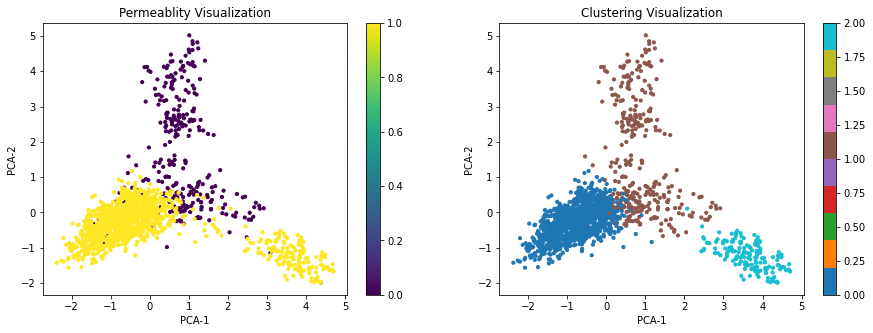

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(components[:,0], components[:,1], c=bbb_df['permeable'],s=10)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Permeablity Visualization')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(components[:,0], components[:,1], c=cluster_index,s=10, cmap='tab10')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Clustering Visualization')
plt.colorbar()

## t-SNE

In [23]:
tsne = TSNE(n_components=2)
t_components = tsne.fit_transform(components)

C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


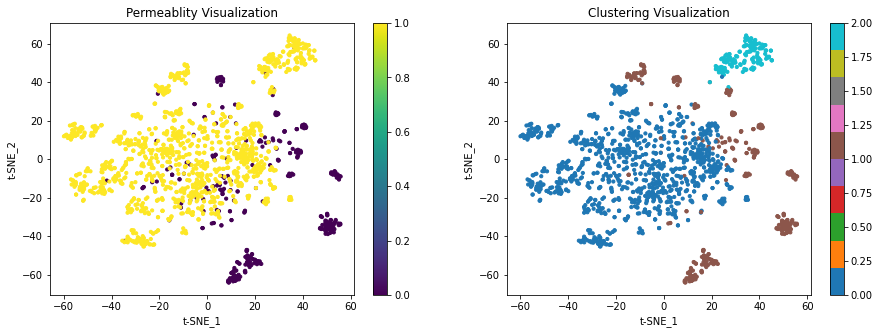

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(t_components[:,0], t_components[:,1], c=bbb_df['permeable'],s=10)
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Permeablity Visualization')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(t_components[:,0], t_components[:,1], c=cluster_index,s=10, cmap='tab10')
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Clustering Visualization')
plt.colorbar()